# Data Wranger Script

Converts long feature file into wide feature file so we can train on it

In [2]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import sys

print("--- Part 1: Feature Wrangler (Fixed Paths) ---")

# --- 1. Configuration ---

# --- Path Configuration ---
# Assume this script is in a 'notebooks' or 'training' folder
# And the project root is one level up
try:
    PROJECT_ROOT = Path.cwd().parent
    PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
    # Ensure the output directory exists
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
except Exception as e:
    print(f"Error setting up paths: {e}")
    print("Please ensure you are running this from a subdirectory of your project root.")
    sys.exit(1)


# Define file paths based on your config
# This is the input file from your preparation script
CATCH_22_FILE = PROCESSED_DIR / 'aki_pleth_ecg_co2_awp_inf.csv'
TARGET_COLUMN = 'aki_label' # From your config (OUTCOME)

# This will be the new output file
WIDE_FEATURES_FILE = PROCESSED_DIR / 'aki_features_master_wide.csv'


print(f"Project Root:        {PROJECT_ROOT}")
print(f"Input (long) file:   {CATCH_22_FILE}")
print(f"Output (wide) file:  {WIDE_FEATURES_FILE}")

# --- 2. Load Long-Format Data ---
print("\nLoading long-format data...")
try:
    long_df = pd.read_csv(CATCH_22_FILE)
    print(f"Successfully loaded. Shape: {long_df.shape}")
    # print(long_df.head())
except FileNotFoundError:
    print(f"ERROR: Input file not found at {CATCH_22_FILE}")
    print("Please ensure the preparation script has been run and the file exists.")
    sys.exit(1)
except Exception as e:
    print(f"An unexpected error occurred while loading the file: {e}")
    sys.exit(1)

# --- 3. Pivot to Wide Format ---
print("\nPivoting data from long to wide format...")

# Identify columns
# ID/Target cols: These will form the index of the pivot
id_cols = ['caseid', TARGET_COLUMN]
pivot_col = 'waveform'

# Check if target column exists
if TARGET_COLUMN not in long_df.columns:
    print(f"ERROR: Target column '{TARGET_COLUMN}' not found in the input file.")
    print(f"Available columns are: {long_df.columns.tolist()}")
    sys.exit(1)

# Feature cols: These are all other columns that will be "pivoted"
# We exclude the ID cols and the pivot col
feature_cols = [col for col in long_df.columns if col not in id_cols + [pivot_col]]

if not feature_cols:
    print("ERROR: No feature columns found. Check your input CSV.")
    # Raise error to stop execution
    raise ValueError("No feature columns detected to pivot.")

print(f"Pivoting by 'caseid' and '{TARGET_COLUMN}' on {len(feature_cols)} features.")

# Use pivot_table.
# 'index' keeps 'caseid' and 'aki_label' as the unique identifiers for a row.
# 'columns' flips the 'waveform' values into new columns.
# 'values' are the feature values to fill the table.
wide_df = long_df.pivot_table(
    index=id_cols,
    columns=pivot_col,
    values=feature_cols
)

print(f"Pivot complete. Shape before flattening: {wide_df.shape}")

# --- 4. Flatten and Clean Column Names ---
print("Flattening and cleaning column names...")

# The pivot creates a MultiIndex, e.g., ('DN_HistogramMode_10', 'SNUADC/PLETH')
# We want to flatten this to a single name, e.g., 'SNUADC_PLETH_DN_HistogramMode_10'
# We also replace '/' with '_' for compatibility.

new_cols = []
for feature_name, waveform_name in wide_df.columns:
    # Replace slashes (e.g., in 'SNUADC/PLETH') with underscores
    clean_waveform = waveform_name.replace('/', '_')
    
    # Create the new flat column name
    new_cols.append(f"{clean_waveform}_{feature_name}")

# Assign the new, flat column names
wide_df.columns = new_cols

# 'caseid' and 'aki_label' are currently in the index.
# .reset_index() moves them back to being regular columns.
wide_df = wide_df.reset_index()

print(f"Column names flattened. Shape after reset_index: {wide_df.shape}")

# --- 5. Impute Missing Values ---
# After the pivot, any patient missing a waveform will have NaNs for those features.
# As planned, we will fill these with 0.
print("Imputing missing values (from missing waveforms) with 0...")

nan_count_before = wide_df.isna().sum().sum()

# Fill all NaNs with 0
wide_df.fillna(0, inplace=True)

nan_count_after = wide_df.isna().sum().sum()

print(f"Total NaN values filled: {nan_count_before}")
print(f"Remaining NaN values: {nan_count_after}")

# --- 6. Save Master Wide-Format File ---
print(f"\nSaving new master wide-format file to {WIDE_FEATURES_FILE}...")
wide_df.to_csv(WIDE_FEATURES_FILE, index=False)

print("---")
print("✅ Wrangler script complete.")
print("\n--- Final Output Sample ---")
# Display the first 5 rows and first 7 columns for readability
print(wide_df.iloc[:, :7].head())

--- Part 1: Feature Wrangler (Fixed Paths) ---
Project Root:        d:\Projects\aki_prediction_project
Input (long) file:   d:\Projects\aki_prediction_project\data\processed\aki_pleth_ecg_co2_awp_inf.csv
Output (wide) file:  d:\Projects\aki_prediction_project\data\processed\aki_features_master_wide.csv

Loading long-format data...
Successfully loaded. Shape: (13661, 27)

Pivoting data from long to wide format...
Pivoting by 'caseid' and 'aki_label' on 24 features.
Pivot complete. Shape before flattening: (3447, 96)
Flattening and cleaning column names...
Column names flattened. Shape after reset_index: (3447, 98)
Imputing missing values (from missing waveforms) with 0...
Total NaN values filled: 3048
Remaining NaN values: 0

Saving new master wide-format file to d:\Projects\aki_prediction_project\data\processed\aki_features_master_wide.csv...
---
✅ Wrangler script complete.

--- Final Output Sample ---
   caseid  aki_label  Primus_AWP_CO_Embed2_Dist_tau_d_expfit_meandiff  \
0       1  

# Training (Script Compatible)

Updated code to work with Nidhir's modular scripts

In [4]:
# =============================================================================
# MODULAR XGBOOST TRAINING SCRIPT
#
# This script performs a complete ML workflow with modular waveform selection:
# 1. Loads the "master wide" feature file.
# 2. Selects feature subsets based on a configuration setting.
# 3. Splits data into a main training set and a final, hold-out test set.
# 4. Performs Optuna HPO using Stratified K-Fold Cross-Validation.
#    - Caching: Checks for existing HPO results and skips HPO if found.
# 5. Trains a final model on the entire main training set using the best params.
# 6. Evaluates the final model on the hold-out test set and saves all
#    results (metrics, plots, SHAP) to a unique folder.
#
# To run, edit the `TRAINING_MODE` dict and the main runner (Cell 5).
# =============================================================================

# --- Cell 1: Imports and Setup -----------------------------------------------
import time
import logging
from pathlib import Path
import os
import sys
import ast

import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from xgboost.callback import EarlyStopping
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(levelname)s — %(message)s",
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("--- Libraries imported and logging configured ---")


# --- Cell 2: Configuration and Paths -----------------------------------------
N_TRIALS = 100 # Number of HPO trials
N_SPLITS = 5   # Number of folds for cross-validation
RANDOM_STATE = 42

# --- HPO Caching ---
# If True, the script will look for 'hpo_best_params.txt' and skip HPO if found.
USE_HPO_CACHING = True
# If True, HPO will re-run even if a cache file exists.
FORCE_HPO_RERUN = False

# --- Path Configuration ---
# Assume this script is in a 'notebooks' or 'training' folder
# And the project root is one level up
PROJECT_ROOT = Path.cwd().parent
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"

# --- MODULAR TRAINING SETUP ---
# This is the master "wide" file created by the wrangler script
MASTER_WIDE_FILE = PROCESSED_DIR / 'aki_features_master_wide.csv'
TARGET_COLUMN = "aki_label"

# Define your training "modes"
# 'waveforms' can be a list of waveform names, or None to use all.
# Waveform names must match the prefixes created by the wrangler
# (e.g., 'SNUADC_PLETH', 'Primus_CO2', etc.)
TRAINING_MODE = {
    'pleth_only': {
        'waveforms': ['SNUADC_PLETH']
    },
    'ecg_only': {
        'waveforms': ['SNUADC_ECG_II']
    },
    'co2_only': {
        'waveforms': ['Primus_CO2']
    },
    'awp_only': {
        'waveforms': ['Primus_AWP']
    },
    'pleth_and_ecg': {
        'waveforms': ['SNUADC_PLETH', 'SNUADC_ECG_II']
    },
    'all_waveforms': {
        'waveforms': None  # 'None' is a special key to use all features
    }
}


# --- Cell 3: Helper Functions ------------------------------------------------

def parse_hpo_params(filepath: Path) -> dict:
    """
    Parses the 'hpo_best_params.txt' file and returns the params dict.
    Uses ast.literal_eval for safe parsing of the dictionary string.
    """
    with open(filepath, 'r') as f:
        content = f.read()
    
    # Find the dictionary string
    dict_start = content.find('{')
    dict_end = content.rfind('}') + 1
    
    if dict_start == -1 or dict_end == -1:
        raise ValueError(f"Could not find dictionary in {filepath}")
        
    dict_string = content[dict_start:dict_end]
    
    # Safely evaluate the string as a Python dictionary
    params = ast.literal_eval(dict_string)
    return params

def write_hpo_params(filepath: Path, params: dict, best_value: float):
    """
    Writes the HPO parameters and best score to the specified file
    in the "copy-paste ready" format.
    """
    output_string_list = ["hpo_params_xgboost = {"]
    for k, v in params.items():
        output_string_list.append(f"    '{k}': {v!r},")
    output_string_list.append("}")
    final_output_string = "\n".join(output_string_list)

    with open(filepath, "w") as f:
        f.write(f"# Hyperparameters saved on {time.ctime()}\n")
        f.write(f"# Best CV AUROC from HPO: {best_value:.4f}\n")
        f.write(final_output_string)
    logging.info(f"Best parameters written to {filepath}")


def objective(trial, X, y):
    """Optuna objective that uses Stratified K-Fold CV and returns mean AUROC."""
    
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    auroc_scores = []

    # Calculate scale_pos_weight on the full training data once
    neg, pos = np.bincount(y)
    spw = np.sqrt(neg / pos) if pos > 0 else 1.0

    params = {
        "objective": "binary:logistic", "booster": "gbtree", "eval_metric": "auc",
        "tree_method": "hist", "n_jobs": -1, "random_state": RANDOM_STATE, "verbosity": 0,
        "scale_pos_weight": spw,
        "n_estimators": trial.suggest_int("n_estimators", 200, 2000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.05, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        "callbacks": [EarlyStopping(rounds=50)],
    }

    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        model = xgb.XGBClassifier(**params)
        model.fit(X_tr_s, y_tr, eval_set=[(X_val_s, y_val)], verbose=False)
        
        y_hat = model.predict_proba(X_val_s)[:, 1]
        auroc_scores.append(roc_auc_score(y_val, y_hat))

    return np.mean(auroc_scores)

print("--- Optuna objective function and helpers defined ---")


# --- Cell 4: Main Execution Block --------------------------------------------
def run_hpo_and_evaluate(mode_to_run: str):
    """
    Main function to run the entire HPO and evaluation pipeline
    for a single, specified training mode.
    """
    
    # --- Dynamic Path Configuration ---
    try:
        config = TRAINING_MODE[mode_to_run]
        RESULTS_SUFFIX = mode_to_run
    except KeyError:
        print(f"ERROR: Mode '{mode_to_run}' not found in TRAINING_MODE dictionary.")
        print(f"Available modes are: {list(TRAINING_MODE.keys())}")
        return # Skip this mode if invalid

    RESULTS_DIR = PROJECT_ROOT / "results" / f"xgboost_{RESULTS_SUFFIX}"
    HPO_RESULTS_FILE = RESULTS_DIR / "hpo_best_params.txt"

    # Create the unique results directory for this run
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)

    logging.info(f"--- 🚀 Starting Run For Mode: {mode_to_run} ---")
    logging.info(f"Project Root set to: {PROJECT_ROOT}")
    logging.info(f"Data file set to: {MASTER_WIDE_FILE}")
    logging.info(f"Results will be saved in: {RESULTS_DIR}")

    # ---------- Load Data ----------
    csv_path = Path(MASTER_WIDE_FILE)
    try:
        df = pd.read_csv(csv_path)
        logging.info(f"Data loaded successfully from {csv_path}")
    except FileNotFoundError:
        logging.error(f"Error loading data: {csv_path} not found.")
        logging.error("Please run the 'Part 1: Feature Wrangler' script first.")
        return

    # ---------- Dynamic Feature Selection ----------
    logging.info(f"Selecting features for mode: {mode_to_run}...")
    
    all_feature_cols = [col for col in df.columns if col not in ['caseid', TARGET_COLUMN]]
    selected_waveforms = config['waveforms']
    
    if selected_waveforms is None:
        selected_cols = all_feature_cols
        logging.info(f"Using all {len(selected_cols)} features.")
    else:
        selected_cols = []
        for prefix in selected_waveforms:
            cols_for_wf = [col for col in all_feature_cols if col.startswith(prefix)]
            if not cols_for_wf:
                logging.warning(f"No columns found with prefix: {prefix}")
            selected_cols.extend(cols_for_wf)
        
        if not selected_cols:
            logging.error(f"No features selected for mode {mode_to_run}. Check prefixes.")
            return
        logging.info(f"Selected {len(selected_cols)} features based on {selected_waveforms}.")

    X = df[selected_cols]
    y = df[TARGET_COLUMN]

    if X.isna().any().any():
        logging.warning("NaN values detected in X. Filling with 0.")
        X = X.fillna(0)

    # ---------- Create a final hold-out test set ----------
    X_train_main, X_test, y_train_main, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    logging.info(f"Data split into main training set ({len(y_train_main)} samples) and hold-out test set ({len(y_test)} samples).")

    # ---------- Optuna Study with CV (and Caching) ----------
    best_params = None
    logging.info("--- Checking for HPO cache ---")
    
    if USE_HPO_CACHING and not FORCE_HPO_RERUN and HPO_RESULTS_FILE.exists():
        try:
            best_params = parse_hpo_params(HPO_RESULTS_FILE)
            logging.info(f"Loaded cached HPO params from {HPO_RESULTS_FILE}")
        except Exception as e:
            logging.warning(f"Failed to load HPO cache: {e}. Re-running HPO.")
            
    if best_params is None:
        if FORCE_HPO_RERUN:
            logging.info("FORCE_HPO_RERUN is True. Forcing HPO.")
        
        logging.info(f"Starting Optuna study with {N_TRIALS} trials and {N_SPLITS}-Fold CV...")
        study = optuna.create_study(direction="maximize")
        study.optimize(
            lambda trial: objective(trial, X_train_main, y_train_main),
            n_trials=N_TRIALS,
            show_progress_bar=True,
        )
        logging.info("HPO complete.")
        
        best_params = dict(study.best_params)
        
        # Write the new HPO results to the cache file
        write_hpo_params(HPO_RESULTS_FILE, best_params, study.best_value)

    # ---------- Train and Evaluate Final Model on Hold-Out Set ----------
    logging.info("Training and evaluating the best model on the hold-out test set...")
    
    # Add scale_pos_weight, which is not part of the HPO params
    neg, pos = np.bincount(y_train_main)
    best_params["scale_pos_weight"] = np.sqrt(neg / pos) if pos > 0 else 1.0
    
    final_model_params = {
        "objective": "binary:logistic", "booster": "gbtree", "tree_method": "hist",
        "n_jobs": -1, "random_state": RANDOM_STATE, **best_params,
    }

    scaler = StandardScaler()
    X_train_main_s = scaler.fit_transform(X_train_main)
    X_test_s = scaler.transform(X_test)

    final_model = xgb.XGBClassifier(**final_model_params)
    final_model.fit(X_train_main_s, y_train_main)
    
    y_test_pred_proba = final_model.predict_proba(X_test_s)[:, 1]

    # --- Find Optimal Threshold on Test Set ---
    thresholds = np.arange(0.01, 1.0, 0.01)
    f1_scores = [f1_score(y_test, y_test_pred_proba >= t) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    logging.info(f"Best threshold found on test set: {best_threshold:.2f}")
    y_test_pred_class = (y_test_pred_proba >= best_threshold).astype(int)

    # --- Calculate All Performance Metrics ---
    metrics = {
        'AUROC': roc_auc_score(y_test, y_test_pred_proba),
        'AUPRC': average_precision_score(y_test, y_test_pred_proba),
        'Accuracy': accuracy_score(y_test, y_test_pred_class),
        'Precision': precision_score(y_test, y_test_pred_class, zero_division=0),
        'Sensitivity (Recall)': recall_score(y_test, y_test_pred_class),
        'F1-Score (Maximized)': f1_score(y_test, y_test_pred_class)
    }
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_class).ravel()
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metrics_df = pd.DataFrame(metrics.items(), columns=['Metric', 'Score'])
    print("\n--- 📊 Final Model Performance on Hold-Out Test Set ---")
    print(metrics_df.round(4))
    metrics_df.to_csv(RESULTS_DIR / "final_metrics.csv", index=False)
    logging.info(f"Metrics saved to {RESULTS_DIR / 'final_metrics.csv'}")

    # --- Plot Confusion Matrix ---
    cm = confusion_matrix(y_test, y_test_pred_class)
    fig, ax = plt.subplots(figsize=(7, 6))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2. else "black")
    ax.set_xticks(np.arange(2)), ax.set_yticks(np.arange(2))
    ax.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
    ax.set_yticklabels(['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix on Hold-Out Test Data', fontsize=16, pad=20)
    plt.savefig(RESULTS_DIR / "confusion_matrix.png", dpi=300, bbox_inches='tight')
    plt.close(fig) # Close figure to save memory
    logging.info(f"Confusion matrix saved to {RESULTS_DIR / 'confusion_matrix.png'}")

    # --- SHAP Analysis ---
    logging.info("Calculating SHAP values for model explainability...")
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_test_s)
    
    logging.info("--- Saving SHAP Feature Importance (Bar Plot) ---")
    fig, ax = plt.subplots(figsize=(10, max(10, len(X.columns) * 0.5))) # Dynamic height
    shap.summary_plot(shap_values, X_test_s, feature_names=X.columns, plot_type="bar", show=False, max_display=50)
    ax.set_title("Global Feature Importance (Mean Absolute SHAP Value)", fontsize=16, pad=20)
    plt.savefig(RESULTS_DIR / "shap_summary_bar.png", dpi=300, bbox_inches='tight')
    plt.close(fig) # Close figure
    logging.info(f"SHAP bar plot saved to {RESULTS_DIR / 'shap_summary_bar.png'}")

    logging.info("--- Saving SHAP Feature Importance (Dot Plot) ---")
    fig, ax = plt.subplots(figsize=(10, max(10, len(X.columns) * 0.5))) # Dynamic height
    shap.summary_plot(shap_values, X_test_s, feature_names=X.columns, plot_type="dot", show=False, max_display=50)
    ax.set_title("SHAP Summary Plot (Feature Impact)", fontsize=16, pad=20)
    plt.savefig(RESULTS_DIR / "shap_summary_dot.png", dpi=300, bbox_inches='tight')
    plt.close(fig) # Close figure
    logging.info(f"SHAP dot plot saved to {RESULTS_DIR / 'shap_summary_dot.png'}")

    # --- Print Final Parameters (for easy copy-paste) ---
    output_string_list = ["{"]
    for k, v in best_params.items():
        # Exclude scale_pos_weight from the copy-paste-ready output
        if k != "scale_pos_weight":
            output_string_list.append(f"    '{k}': {v!r},")
    output_string_list.append("}")
    final_output_string = "\n".join(output_string_list)
    
    print("\n--- Best Hyperparameters (Copy-Paste Ready) ---")
    print(final_output_string)
    
    logging.info(f"✅ --- Pipeline complete for mode: {mode_to_run} ---")


# --- Cell 5: Run the Full Pipeline -------------------------------------------
if __name__ == "__main__":
    
    # --- Select which modes to run ---
    
    # Option 1: Run a single, specific mode
    # Comment out Option 2 if using this.
    # logging.info("--- Starting single run ---")
    # run_hpo_and_evaluate(mode_to_run='pleth_only')
    # logging.info("--- Single run complete ---")


    # Option 2: Run all modes defined in TRAINING_MODE
    # Comment out Option 1 if using this.
    logging.info("--- Starting batch run for all modes ---")
    
    all_modes = list(TRAINING_MODE.keys()) # Get all keys
    
    for i, mode in enumerate(all_modes):
        logging.info(f"--- Running mode {i+1}/{len(all_modes)}: {mode} ---")
        try:
            run_hpo_and_evaluate(mode_to_run=mode)
        except Exception as e:
            logging.error(f"--- 💥 FAILED run for mode: {mode} ---")
            logging.error(f"Error: {e}")
            # Optional: re-raise the error to stop the whole batch
            # raise e
        
    logging.info("--- ✅ All training runs complete ---")



2025-10-31 13:50:33,813 — INFO — --- Starting batch run for all modes ---
2025-10-31 13:50:33,813 — INFO — --- Running mode 1/6: pleth_only ---
2025-10-31 13:50:33,815 — INFO — --- 🚀 Starting Run For Mode: pleth_only ---
2025-10-31 13:50:33,815 — INFO — Project Root set to: d:\Projects\aki_prediction_project
2025-10-31 13:50:33,816 — INFO — Data file set to: d:\Projects\aki_prediction_project\data\processed\aki_features_master_wide.csv
2025-10-31 13:50:33,817 — INFO — Results will be saved in: d:\Projects\aki_prediction_project\results\xgboost_pleth_only
2025-10-31 13:50:33,882 — INFO — Data loaded successfully from d:\Projects\aki_prediction_project\data\processed\aki_features_master_wide.csv
2025-10-31 13:50:33,883 — INFO — Selecting features for mode: pleth_only...
2025-10-31 13:50:33,883 — INFO — Selected 24 features based on ['SNUADC_PLETH'].
2025-10-31 13:50:33,889 — INFO — Data split into main training set (2757 samples) and hold-out test set (690 samples).
2025-10-31 13:50:33,8

--- Libraries imported and logging configured ---
--- Optuna objective function and helpers defined ---


  0%|          | 0/100 [00:00<?, ?it/s]

2025-10-31 13:51:38,101 — INFO — HPO complete.
2025-10-31 13:51:38,108 — INFO — Best parameters written to d:\Projects\aki_prediction_project\results\xgboost_pleth_only\hpo_best_params.txt
2025-10-31 13:51:38,109 — INFO — Training and evaluating the best model on the hold-out test set...
2025-10-31 13:51:39,055 — INFO — Best threshold found on test set: 0.15
2025-10-31 13:51:39,071 — INFO — Metrics saved to d:\Projects\aki_prediction_project\results\xgboost_pleth_only\final_metrics.csv



--- 📊 Final Model Performance on Hold-Out Test Set ---
                 Metric  Score
0                 AUROC 0.6622
1                 AUPRC 0.1136
2              Accuracy 0.8319
3             Precision 0.1238
4  Sensitivity (Recall) 0.3514
5  F1-Score (Maximized) 0.1831
6           Specificity 0.8591


2025-10-31 13:51:39,482 — INFO — Confusion matrix saved to d:\Projects\aki_prediction_project\results\xgboost_pleth_only\confusion_matrix.png
2025-10-31 13:51:39,483 — INFO — Calculating SHAP values for model explainability...
2025-10-31 13:51:39,771 — INFO — --- Saving SHAP Feature Importance (Bar Plot) ---
2025-10-31 13:51:40,743 — INFO — SHAP bar plot saved to d:\Projects\aki_prediction_project\results\xgboost_pleth_only\shap_summary_bar.png
2025-10-31 13:51:40,744 — INFO — --- Saving SHAP Feature Importance (Dot Plot) ---
2025-10-31 13:51:42,241 — INFO — SHAP dot plot saved to d:\Projects\aki_prediction_project\results\xgboost_pleth_only\shap_summary_dot.png
2025-10-31 13:51:42,242 — INFO — ✅ --- Pipeline complete for mode: pleth_only ---
2025-10-31 13:51:42,246 — INFO — --- Running mode 2/6: ecg_only ---
2025-10-31 13:51:42,247 — INFO — --- 🚀 Starting Run For Mode: ecg_only ---
2025-10-31 13:51:42,248 — INFO — Project Root set to: d:\Projects\aki_prediction_project
2025-10-31 13:5


--- Best Hyperparameters (Copy-Paste Ready) ---
{
    'n_estimators': 1300,
    'learning_rate': 0.03152022167221481,
    'max_depth': 8,
    'subsample': 0.7847758956123738,
    'colsample_bytree': 0.7607969491327136,
    'gamma': 4.228499082384407,
    'reg_lambda': 0.0041682938877615205,
    'reg_alpha': 0.3448650875261452,
}


  0%|          | 0/100 [00:00<?, ?it/s]

2025-10-31 13:52:23,809 — INFO — HPO complete.
2025-10-31 13:52:23,814 — INFO — Best parameters written to d:\Projects\aki_prediction_project\results\xgboost_ecg_only\hpo_best_params.txt
2025-10-31 13:52:23,815 — INFO — Training and evaluating the best model on the hold-out test set...
2025-10-31 13:52:26,219 — INFO — Best threshold found on test set: 0.13
2025-10-31 13:52:26,234 — INFO — Metrics saved to d:\Projects\aki_prediction_project\results\xgboost_ecg_only\final_metrics.csv



--- 📊 Final Model Performance on Hold-Out Test Set ---
                 Metric  Score
0                 AUROC 0.5491
1                 AUPRC 0.0641
2              Accuracy 0.7667
3             Precision 0.0753
4  Sensitivity (Recall) 0.2973
5  F1-Score (Maximized) 0.1202
6           Specificity 0.7933


2025-10-31 13:52:26,667 — INFO — Confusion matrix saved to d:\Projects\aki_prediction_project\results\xgboost_ecg_only\confusion_matrix.png
2025-10-31 13:52:26,668 — INFO — Calculating SHAP values for model explainability...
2025-10-31 13:52:28,281 — INFO — --- Saving SHAP Feature Importance (Bar Plot) ---
2025-10-31 13:52:29,274 — INFO — SHAP bar plot saved to d:\Projects\aki_prediction_project\results\xgboost_ecg_only\shap_summary_bar.png
2025-10-31 13:52:29,274 — INFO — --- Saving SHAP Feature Importance (Dot Plot) ---
2025-10-31 13:52:30,803 — INFO — SHAP dot plot saved to d:\Projects\aki_prediction_project\results\xgboost_ecg_only\shap_summary_dot.png
2025-10-31 13:52:30,804 — INFO — ✅ --- Pipeline complete for mode: ecg_only ---
2025-10-31 13:52:30,812 — INFO — --- Running mode 3/6: co2_only ---
2025-10-31 13:52:30,814 — INFO — --- 🚀 Starting Run For Mode: co2_only ---
2025-10-31 13:52:30,814 — INFO — Project Root set to: d:\Projects\aki_prediction_project
2025-10-31 13:52:30,815


--- Best Hyperparameters (Copy-Paste Ready) ---
{
    'n_estimators': 1400,
    'learning_rate': 0.001551443177978052,
    'max_depth': 8,
    'subsample': 0.8270763757926302,
    'colsample_bytree': 0.8904370529672424,
    'gamma': 4.931386142290657,
    'reg_lambda': 2.7236634918777257e-06,
    'reg_alpha': 0.0026671490455087376,
}


  0%|          | 0/100 [00:00<?, ?it/s]

2025-10-31 13:53:00,197 — INFO — HPO complete.
2025-10-31 13:53:00,203 — INFO — Best parameters written to d:\Projects\aki_prediction_project\results\xgboost_co2_only\hpo_best_params.txt
2025-10-31 13:53:00,204 — INFO — Training and evaluating the best model on the hold-out test set...
2025-10-31 13:53:00,610 — INFO — Best threshold found on test set: 0.24
2025-10-31 13:53:00,626 — INFO — Metrics saved to d:\Projects\aki_prediction_project\results\xgboost_co2_only\final_metrics.csv



--- 📊 Final Model Performance on Hold-Out Test Set ---
                 Metric  Score
0                 AUROC 0.6266
1                 AUPRC 0.1016
2              Accuracy 0.9333
3             Precision 0.2000
4  Sensitivity (Recall) 0.0811
5  F1-Score (Maximized) 0.1154
6           Specificity 0.9816


2025-10-31 13:53:01,063 — INFO — Confusion matrix saved to d:\Projects\aki_prediction_project\results\xgboost_co2_only\confusion_matrix.png
2025-10-31 13:53:01,064 — INFO — Calculating SHAP values for model explainability...
2025-10-31 13:53:01,188 — INFO — --- Saving SHAP Feature Importance (Bar Plot) ---
2025-10-31 13:53:02,131 — INFO — SHAP bar plot saved to d:\Projects\aki_prediction_project\results\xgboost_co2_only\shap_summary_bar.png
2025-10-31 13:53:02,131 — INFO — --- Saving SHAP Feature Importance (Dot Plot) ---
2025-10-31 13:53:03,563 — INFO — SHAP dot plot saved to d:\Projects\aki_prediction_project\results\xgboost_co2_only\shap_summary_dot.png
2025-10-31 13:53:03,564 — INFO — ✅ --- Pipeline complete for mode: co2_only ---
2025-10-31 13:53:03,566 — INFO — --- Running mode 4/6: awp_only ---
2025-10-31 13:53:03,567 — INFO — --- 🚀 Starting Run For Mode: awp_only ---
2025-10-31 13:53:03,567 — INFO — Project Root set to: d:\Projects\aki_prediction_project
2025-10-31 13:53:03,568


--- Best Hyperparameters (Copy-Paste Ready) ---
{
    'n_estimators': 300,
    'learning_rate': 0.00019203969826454937,
    'max_depth': 3,
    'subsample': 0.9531027244177532,
    'colsample_bytree': 0.7747220058513691,
    'gamma': 0.3911432341546881,
    'reg_lambda': 0.010584662557713164,
    'reg_alpha': 0.057699880978667566,
}


  0%|          | 0/100 [00:00<?, ?it/s]

2025-10-31 13:53:31,528 — INFO — HPO complete.
2025-10-31 13:53:31,540 — INFO — Best parameters written to d:\Projects\aki_prediction_project\results\xgboost_awp_only\hpo_best_params.txt
2025-10-31 13:53:31,541 — INFO — Training and evaluating the best model on the hold-out test set...
2025-10-31 13:53:32,374 — INFO — Best threshold found on test set: 0.23
2025-10-31 13:53:32,395 — INFO — Metrics saved to d:\Projects\aki_prediction_project\results\xgboost_awp_only\final_metrics.csv



--- 📊 Final Model Performance on Hold-Out Test Set ---
                 Metric  Score
0                 AUROC 0.6842
1                 AUPRC 0.1608
2              Accuracy 0.9217
3             Precision 0.2258
4  Sensitivity (Recall) 0.1892
5  F1-Score (Maximized) 0.2059
6           Specificity 0.9632


2025-10-31 13:53:32,914 — INFO — Confusion matrix saved to d:\Projects\aki_prediction_project\results\xgboost_awp_only\confusion_matrix.png
2025-10-31 13:53:32,915 — INFO — Calculating SHAP values for model explainability...
2025-10-31 13:53:32,981 — INFO — --- Saving SHAP Feature Importance (Bar Plot) ---
2025-10-31 13:53:34,043 — INFO — SHAP bar plot saved to d:\Projects\aki_prediction_project\results\xgboost_awp_only\shap_summary_bar.png
2025-10-31 13:53:34,044 — INFO — --- Saving SHAP Feature Importance (Dot Plot) ---
2025-10-31 13:53:35,806 — INFO — SHAP dot plot saved to d:\Projects\aki_prediction_project\results\xgboost_awp_only\shap_summary_dot.png
2025-10-31 13:53:35,806 — INFO — ✅ --- Pipeline complete for mode: awp_only ---
2025-10-31 13:53:35,808 — INFO — --- Running mode 5/6: pleth_and_ecg ---
2025-10-31 13:53:35,810 — INFO — --- 🚀 Starting Run For Mode: pleth_and_ecg ---
2025-10-31 13:53:35,810 — INFO — Project Root set to: d:\Projects\aki_prediction_project
2025-10-31 13


--- Best Hyperparameters (Copy-Paste Ready) ---
{
    'n_estimators': 200,
    'learning_rate': 0.0001243975599872618,
    'max_depth': 3,
    'subsample': 0.7286211314730234,
    'colsample_bytree': 0.7469935123922621,
    'gamma': 0.28943538718277945,
    'reg_lambda': 0.13339764145968971,
    'reg_alpha': 1.9463549553043227e-06,
}


  0%|          | 0/100 [00:00<?, ?it/s]

2025-10-31 13:54:50,093 — INFO — HPO complete.
2025-10-31 13:54:50,101 — INFO — Best parameters written to d:\Projects\aki_prediction_project\results\xgboost_pleth_and_ecg\hpo_best_params.txt
2025-10-31 13:54:50,101 — INFO — Training and evaluating the best model on the hold-out test set...
2025-10-31 13:54:50,740 — INFO — Best threshold found on test set: 0.20
2025-10-31 13:54:50,768 — INFO — Metrics saved to d:\Projects\aki_prediction_project\results\xgboost_pleth_and_ecg\final_metrics.csv



--- 📊 Final Model Performance on Hold-Out Test Set ---
                 Metric  Score
0                 AUROC 0.6541
1                 AUPRC 0.0868
2              Accuracy 0.6652
3             Precision 0.0890
4  Sensitivity (Recall) 0.5676
5  F1-Score (Maximized) 0.1538
6           Specificity 0.6708


2025-10-31 13:54:51,214 — INFO — Confusion matrix saved to d:\Projects\aki_prediction_project\results\xgboost_pleth_and_ecg\confusion_matrix.png
2025-10-31 13:54:51,214 — INFO — Calculating SHAP values for model explainability...
2025-10-31 13:54:51,340 — INFO — --- Saving SHAP Feature Importance (Bar Plot) ---
2025-10-31 13:54:52,954 — INFO — SHAP bar plot saved to d:\Projects\aki_prediction_project\results\xgboost_pleth_and_ecg\shap_summary_bar.png
2025-10-31 13:54:52,955 — INFO — --- Saving SHAP Feature Importance (Dot Plot) ---
2025-10-31 13:54:55,725 — INFO — SHAP dot plot saved to d:\Projects\aki_prediction_project\results\xgboost_pleth_and_ecg\shap_summary_dot.png
2025-10-31 13:54:55,725 — INFO — ✅ --- Pipeline complete for mode: pleth_and_ecg ---
2025-10-31 13:54:55,728 — INFO — --- Running mode 6/6: all_waveforms ---
2025-10-31 13:54:55,728 — INFO — --- 🚀 Starting Run For Mode: all_waveforms ---
2025-10-31 13:54:55,729 — INFO — Project Root set to: d:\Projects\aki_prediction_p


--- Best Hyperparameters (Copy-Paste Ready) ---
{
    'n_estimators': 200,
    'learning_rate': 0.0024221025382925735,
    'max_depth': 5,
    'subsample': 0.9816361563955359,
    'colsample_bytree': 0.836740947047681,
    'gamma': 1.0663905271259706,
    'reg_lambda': 0.9650438328633204,
    'reg_alpha': 2.9310482321743765e-05,
}


  0%|          | 0/100 [00:00<?, ?it/s]

2025-10-31 13:55:59,329 — INFO — HPO complete.
2025-10-31 13:55:59,335 — INFO — Best parameters written to d:\Projects\aki_prediction_project\results\xgboost_all_waveforms\hpo_best_params.txt
2025-10-31 13:55:59,336 — INFO — Training and evaluating the best model on the hold-out test set...
2025-10-31 13:56:01,320 — INFO — Best threshold found on test set: 0.26
2025-10-31 13:56:01,336 — INFO — Metrics saved to d:\Projects\aki_prediction_project\results\xgboost_all_waveforms\final_metrics.csv



--- 📊 Final Model Performance on Hold-Out Test Set ---
                 Metric  Score
0                 AUROC 0.6571
1                 AUPRC 0.2014
2              Accuracy 0.9246
3             Precision 0.2857
4  Sensitivity (Recall) 0.2703
5  F1-Score (Maximized) 0.2778
6           Specificity 0.9617


2025-10-31 13:56:01,779 — INFO — Confusion matrix saved to d:\Projects\aki_prediction_project\results\xgboost_all_waveforms\confusion_matrix.png
2025-10-31 13:56:01,780 — INFO — Calculating SHAP values for model explainability...
2025-10-31 13:56:02,069 — INFO — --- Saving SHAP Feature Importance (Bar Plot) ---
2025-10-31 13:56:03,922 — INFO — SHAP bar plot saved to d:\Projects\aki_prediction_project\results\xgboost_all_waveforms\shap_summary_bar.png
2025-10-31 13:56:03,922 — INFO — --- Saving SHAP Feature Importance (Dot Plot) ---
2025-10-31 13:56:06,817 — INFO — SHAP dot plot saved to d:\Projects\aki_prediction_project\results\xgboost_all_waveforms\shap_summary_dot.png
2025-10-31 13:56:06,818 — INFO — ✅ --- Pipeline complete for mode: all_waveforms ---
2025-10-31 13:56:06,822 — INFO — --- ✅ All training runs complete ---



--- Best Hyperparameters (Copy-Paste Ready) ---
{
    'n_estimators': 1000,
    'learning_rate': 0.00017642144524056597,
    'max_depth': 3,
    'subsample': 0.9725985755760304,
    'colsample_bytree': 0.916768762854823,
    'gamma': 2.5987691423474137,
    'reg_lambda': 1.0009771239671756e-05,
    'reg_alpha': 0.349418085360254,
}


# Depreceated Code, Pre Script Converstion by Nidhir

2025-07-27 03:42:03,911 — INFO — 🚀 Starting XGBoost HPO with Cross-Validation...
2025-07-27 03:42:04,014 — INFO — Data loaded successfully from d:\Projects\aki_prediction_project\data\processed\waveform_catch22_features_sliding_window.csv
2025-07-27 03:42:04,023 — INFO — Data split into main training set (3805 samples) and hold-out test set (952 samples).
2025-07-27 03:42:04,024 — INFO — Starting Optuna study with 100 trials and 5-Fold CV...


--- Libraries imported and logging configured ---
Project Root set to: d:\Projects\aki_prediction_project
Data directory set to: d:\Projects\aki_prediction_project\data\processed
--- Optuna objective function with Stratified K-Fold CV defined ---


  0%|          | 0/100 [00:00<?, ?it/s]

2025-07-27 03:43:38,622 — INFO — HPO complete. Training and evaluating the best model on the hold-out test set...
2025-07-27 03:43:45,370 — INFO — Best threshold found on test set: 0.16



--- 📊 Final Model Performance on Hold-Out Test Set ---


,Metric,Score
0,AUROC,0.5773
1,AUPRC,0.0222
2,Accuracy,0.9790
3,Precision,0.0714
4,Sensitivity (Recall),0.1250
5,F1-Score (Maximized),0.0909
6,Specificity,0.9862


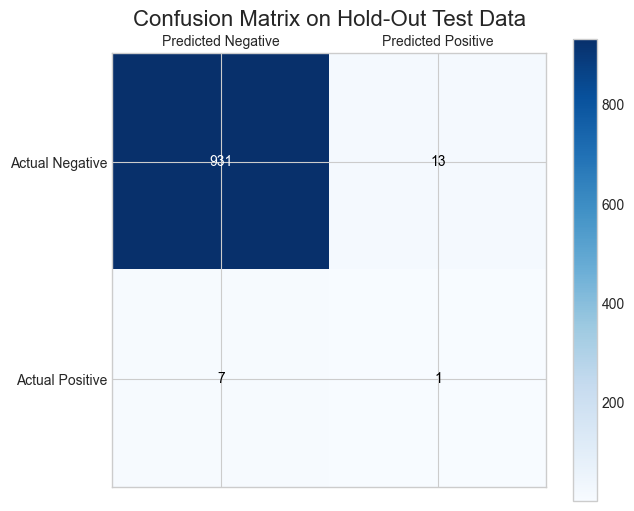

2025-07-27 03:43:45,574 — INFO — Calculating SHAP values for model explainability...



--- SHAP Feature Importance ---


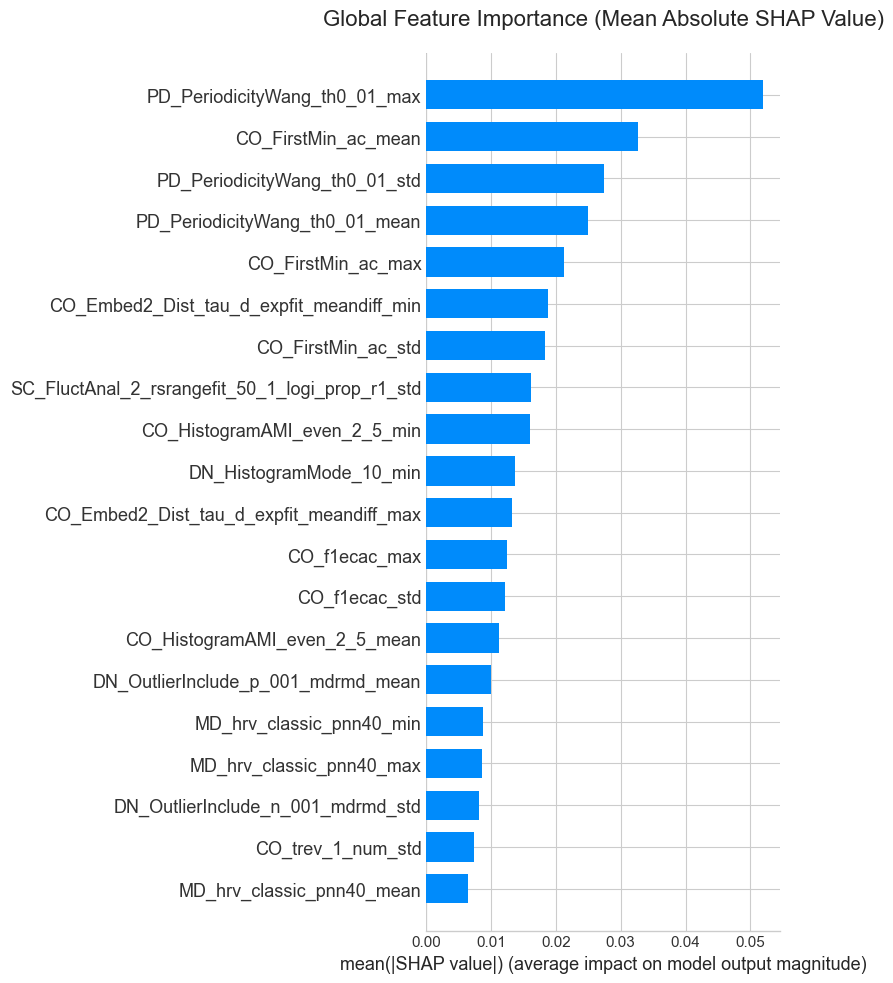

2025-07-27 03:43:47,855 — INFO — Best parameters written to d:\Projects\aki_prediction_project\results\xgboost_sliding_window_bootstrap\hpo_best_params_from_notebook_cv.txt



--- Best Hyperparameters (Copy-Paste Ready) ---
hpo_params_xgboost = {
    'n_estimators': 1400,
    'learning_rate': 0.00034898010421986915,
    'max_depth': 9,
    'subsample': 0.9634335513150067,
    'colsample_bytree': 0.6311601528618799,
    'gamma': 1.7321005335634188,
    'reg_lambda': 0.89884911281541,
    'reg_alpha': 4.455836417400764e-05,
    'scale_pos_weight': np.float64(10.858464440241999),
}


In [12]:
# =============================================================================
# HPO with Cross-Validation, Final Evaluation & SHAP Analysis
#
# This script performs a complete ML workflow in a single notebook:
# 1. Splits data into a main training set and a final, hold-out test set.
# 2. Performs Optuna HPO using Stratified K-Fold Cross-Validation on the
#    main training set for robust hyperparameter tuning.
# 3. Trains a final model on the entire main training set using the best params.
# 4. Evaluates the final model on the hold-out test set, including finding
#    an optimal threshold, plotting a confusion matrix, and generating SHAP plots.
#
# NOTE: This notebook is designed to be run from a 'notebooks' subdirectory
# within your main project folder.
# =============================================================================

# --- Cell 1: Imports and Setup -----------------------------------------------
import time
import logging
from pathlib import Path

import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from xgboost.callback import EarlyStopping
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
)

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s — %(levelname)s — %(message)s",
)
optuna.logging.set_verbosity(optuna.logging.WARNING)
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("--- Libraries imported and logging configured ---")


# --- Cell 2: Configuration and Paths -----------------------------------------
N_TRIALS = 100 # Number of HPO trials
N_SPLITS = 5   # Number of folds for cross-validation
RANDOM_STATE = 42
INPUT_CSV = "waveform_catch22_features_sliding_window.csv"
TARGET_COLUMN = "death_label"

PROJECT_ROOT = Path.cwd().parent
PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR = PROJECT_ROOT / "results" / "xgboost_sliding_window_bootstrap"
HPO_RESULTS_FILE = RESULTS_DIR / "hpo_best_params_from_notebook_cv.txt"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

print(f"Project Root set to: {PROJECT_ROOT}")
print(f"Data directory set to: {PROCESSED_DIR}")


# --- Cell 3: Optuna Objective Function with Cross-Validation -----------------
def objective(trial, X, y):
    """Optuna objective that uses Stratified K-Fold CV and returns mean AUROC."""
    
    cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
    auroc_scores = []

    # Calculate scale_pos_weight on the full training data once
    neg, pos = np.bincount(y)
    spw = np.sqrt(neg / pos) if pos > 0 else 1.0

    params = {
        "objective": "binary:logistic", "booster": "gbtree", "eval_metric": "auc",
        "tree_method": "hist", "n_jobs": -1, "random_state": RANDOM_STATE, "verbosity": 0,
        "scale_pos_weight": spw,
        "n_estimators": trial.suggest_int("n_estimators", 200, 2000, step=100),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.05, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0, log=True),
        # FIX: Removed `save_best=True` which can cause an error if a model
        # in a CV fold trains for all epochs without stopping early. The core
        # functionality of stopping at the best iteration is retained.
        "callbacks": [EarlyStopping(rounds=50)],
    }

    for train_idx, val_idx in cv.split(X, y):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        scaler = StandardScaler()
        X_tr_s = scaler.fit_transform(X_tr)
        X_val_s = scaler.transform(X_val)

        model = xgb.XGBClassifier(**params)
        model.fit(X_tr_s, y_tr, eval_set=[(X_val_s, y_val)], verbose=False)
        
        y_hat = model.predict_proba(X_val_s)[:, 1]
        auroc_scores.append(roc_auc_score(y_val, y_hat))

    return np.mean(auroc_scores)

print("--- Optuna objective function with Stratified K-Fold CV defined ---")


# --- Cell 4: Main Execution Block --------------------------------------------
def run_hpo_and_evaluate():
    """Main function to run the entire HPO and evaluation pipeline."""
    logging.info("🚀 Starting XGBoost HPO with Cross-Validation...")

    # ---------- Load Data ----------
    csv_path = PROCESSED_DIR / INPUT_CSV
    try:
        df = pd.read_csv(csv_path).dropna()
        X = df.drop(columns=["caseid", TARGET_COLUMN])
        y = df[TARGET_COLUMN]
        logging.info(f"Data loaded successfully from {csv_path}")
    except (FileNotFoundError, KeyError) as e:
        logging.error(f"Error loading data: {e}")
        return

    # ---------- Create a final hold-out test set ----------
    # HPO will be performed on X_train_main, y_train_main
    X_train_main, X_test, y_train_main, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
    )
    logging.info(f"Data split into main training set ({len(y_train_main)} samples) and hold-out test set ({len(y_test)} samples).")

    # ---------- Optuna Study with CV ----------
    logging.info(f"Starting Optuna study with {N_TRIALS} trials and {N_SPLITS}-Fold CV...")
    study = optuna.create_study(direction="maximize")
    study.optimize(
        lambda trial: objective(trial, X_train_main, y_train_main),
        n_trials=N_TRIALS,
        show_progress_bar=True,
    )

    # ---------- Train and Evaluate Final Model on Hold-Out Set ----------
    logging.info("HPO complete. Training and evaluating the best model on the hold-out test set...")
    
    best_params = dict(study.best_params)
    neg, pos = np.bincount(y_train_main)
    best_params["scale_pos_weight"] = np.sqrt(neg / pos) if pos > 0 else 1.0
    
    # Note: The 'callbacks' parameter from HPO is not needed for the final model
    final_model_params = {
        "objective": "binary:logistic", "booster": "gbtree", "tree_method": "hist",
        "n_jobs": -1, "random_state": RANDOM_STATE, **best_params,
    }

    # Scale the full main training set and the test set
    scaler = StandardScaler()
    X_train_main_s = scaler.fit_transform(X_train_main)
    X_test_s = scaler.transform(X_test)

    # Train final model
    final_model = xgb.XGBClassifier(**final_model_params)
    final_model.fit(X_train_main_s, y_train_main)
    
    y_test_pred_proba = final_model.predict_proba(X_test_s)[:, 1]

    # --- Find Optimal Threshold on Test Set ---
    thresholds = np.arange(0.01, 1.0, 0.01)
    f1_scores = [f1_score(y_test, y_test_pred_proba >= t) for t in thresholds]
    best_threshold = thresholds[np.argmax(f1_scores)]
    logging.info(f"Best threshold found on test set: {best_threshold:.2f}")
    y_test_pred_class = (y_test_pred_proba >= best_threshold).astype(int)

    # --- Calculate All Performance Metrics ---
    metrics = {
        'AUROC': roc_auc_score(y_test, y_test_pred_proba),
        'AUPRC': average_precision_score(y_test, y_test_pred_proba),
        'Accuracy': accuracy_score(y_test, y_test_pred_class),
        'Precision': precision_score(y_test, y_test_pred_class, zero_division=0),
        'Sensitivity (Recall)': recall_score(y_test, y_test_pred_class),
        'F1-Score (Maximized)': f1_score(y_test, y_test_pred_class)
    }
    tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred_class).ravel()
    metrics['Specificity'] = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    metrics_df = pd.DataFrame(metrics.items(), columns=['Metric', 'Score'])
    print("\n--- 📊 Final Model Performance on Hold-Out Test Set ---")
    display(metrics_df.round(4))

    # --- Plot Confusion Matrix ---
    cm = confusion_matrix(y_test, y_test_pred_class)
    fig, ax = plt.subplots(figsize=(7, 6))
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                    color="white" if cm[i, j] > cm.max()/2. else "black")
    ax.set_xticks(np.arange(2)), ax.set_yticks(np.arange(2))
    ax.set_xticklabels(['Predicted Negative', 'Predicted Positive'])
    ax.set_yticklabels(['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix on Hold-Out Test Data', fontsize=16, pad=20)
    plt.show()

    # --- SHAP Analysis ---
    logging.info("Calculating SHAP values for model explainability...")
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_test_s)
    
    print("\n--- SHAP Feature Importance ---")
    shap.summary_plot(shap_values, X_test_s, feature_names=X.columns, plot_type="bar", show=False)
    plt.title("Global Feature Importance (Mean Absolute SHAP Value)", fontsize=16, pad=20)
    plt.show()

    # --- Print Final Parameters ---
    output_string_list = ["hpo_params_xgboost = {"]
    for k, v in best_params.items():
        output_string_list.append(f"    '{k}': {v!r},")
    output_string_list.append("}")
    final_output_string = "\n".join(output_string_list)
    
    print("\n--- Best Hyperparameters (Copy-Paste Ready) ---")
    print(final_output_string)

    with open(HPO_RESULTS_FILE, "w") as f:
        f.write(f"# Hyperparameters saved on {time.ctime()}\n")
        f.write(f"# Best CV AUROC from HPO: {study.best_value:.4f}\n")
        f.write(final_output_string)
    logging.info(f"Best parameters written to {HPO_RESULTS_FILE}")


# --- Cell 5: Run the Full Pipeline -------------------------------------------
run_hpo_and_evaluate()
